# Customer Satisfaction Analysis

A startup in the logistics and delivery space surveyed their customers regarding the service provided. The aim of this analysis is to determine key features that they should work on to further improve customer satisfaction. 

## Goal
The goal is to try and predict if a customer is happy or not based on the answers they give to the questions being asked. Identify imortant features, and suggest imporvements for future questionaires. 


## Imports 

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.metrics import confusion_matrix, classification_report, matthews_corrcoef, roc_auc_score, roc_curve, auc, f1_score, recall_score, precision_score, accuracy_score
from sklearn.pipeline import Pipeline

from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

## Data

In [2]:
data = pd.read_csv('data.csv')

In [3]:
data.head()

,Y,X1,X2,X3,X4,X5,X6
0,0,3,3,3,4,2,4
1,0,3,2,3,5,4,3
2,1,5,3,3,3,3,5
3,0,5,4,3,3,3,5
4,0,5,4,3,3,3,5


### Target
Y = Labelled target class where 0 indicates unhappy customers and 1 indicates happy customers. 

### Features

X1 = My order was delivered on time <br>
X2 = Contents of my order was as I expected <br>
X3 = I ordered everything I wanted to order <br>
X4 = I paid a good price for my order <br>
X5 = I am satisfied with my courier <br>
X6 = The app makes ordering easy for me <br>

Each of these have a label from 1-5 from customers where a higher number indicates higher satisfaction. 

In [4]:
data.shape

(126, 7)

### Problem: 
So we have Y has the target column, and then we have 6 attritbutes. However we seem to only have 126 samples. 

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Y       126 non-null    int64
 1   X1      126 non-null    int64
 2   X2      126 non-null    int64
 3   X3      126 non-null    int64
 4   X4      126 non-null    int64
 5   X5      126 non-null    int64
 6   X6      126 non-null    int64
dtypes: int64(7)
memory usage: 7.0 KB


In [6]:
data.isnull().sum()

Y     0
X1    0
X2    0
X3    0
X4    0
X5    0
X6    0
dtype: int64

No missing data

In [7]:
data.describe()

,Y,X1,X2,X3,X4,X5,X6
count,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000
mean,0.547619,4.333333,2.531746,3.309524,3.746032,3.650794,4.253968
std,0.499714,0.800000,1.114892,1.023440,0.875776,1.147641,0.809311
min,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,4.000000,2.000000,3.000000,3.000000,3.000000,4.000000
50%,1.000000,5.000000,3.000000,3.000000,4.000000,4.000000,4.000000
75%,1.000000,5.000000,3.000000,4.000000,4.000000,4.000000,5.000000
max,1.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


## Exploratory Data Analysis

In [8]:
data.nunique()

Y     2
X1    4
X2    5
X3    5
X4    5
X5    5
X6    5
dtype: int64

In [9]:
data['X1'].unique()

array([3, 5, 4, 1], dtype=int64)

X1 = 'My order was delivered on time' only has values 1, 3, 4, 5

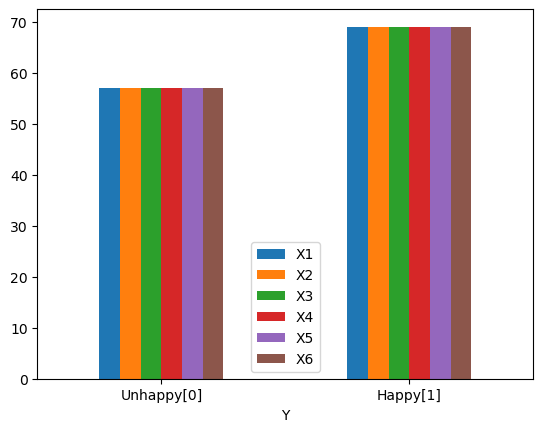

In [10]:
ax = data.groupby('Y').count().plot(kind='bar')
ax.set_xticklabels(['Unhappy[0]', 'Happy[1]'], rotation = 0)
plt.show();

We have an unbalanced dataset: there are more datapoints referring to class 0 than to class 1

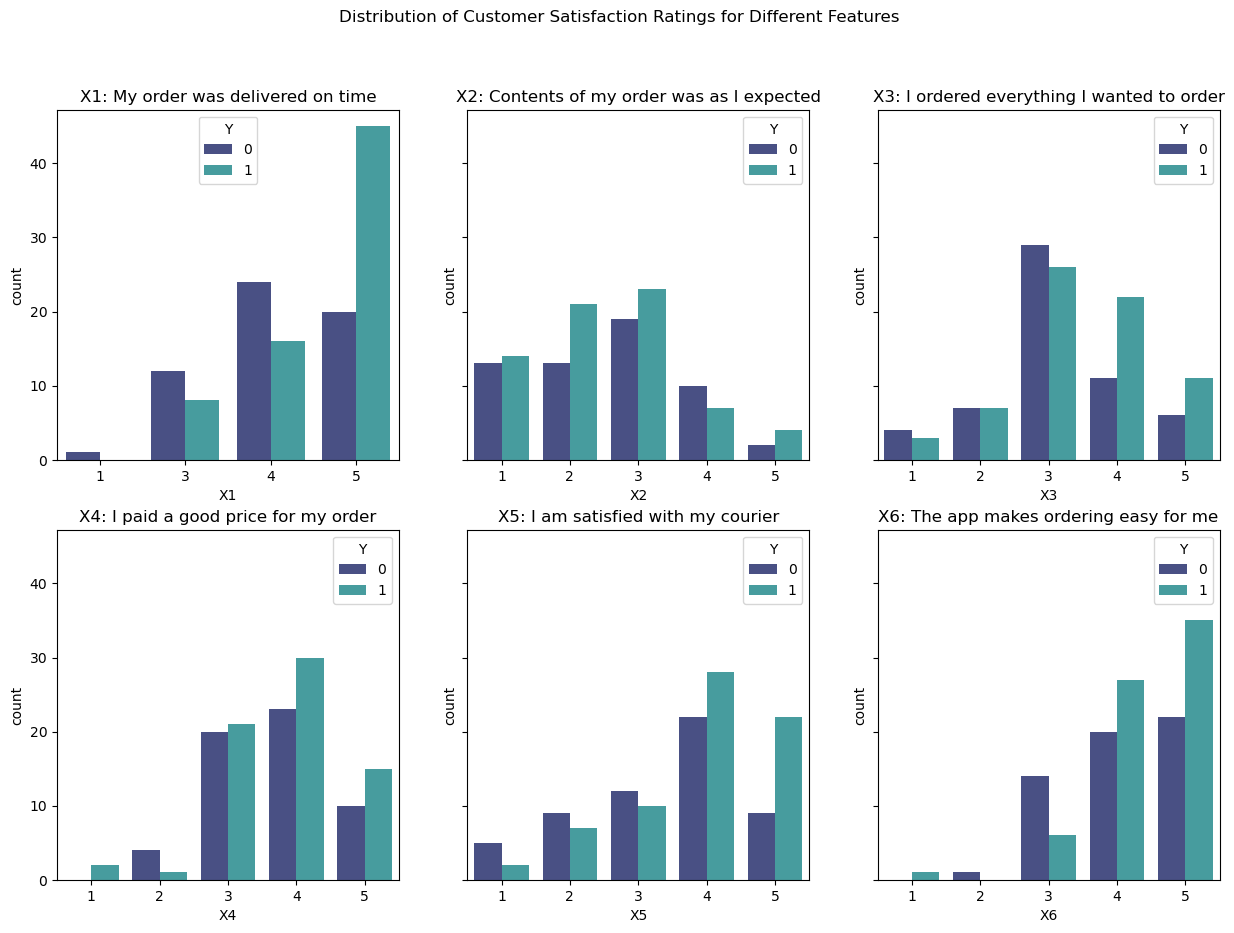

In [11]:
fig , axes = plt.subplots(2,3, sharey= True, figsize = (15,10))
fig.suptitle('Distribution of Customer Satisfaction Ratings for Different Features')

sns.countplot(ax = axes[0,0], x=data['X1'], hue=data['Y'], palette='mako')
axes[0,0].set_title('X1: My order was delivered on time')

sns.countplot(ax = axes[0,1], x=data['X2'], hue=data['Y'], palette='mako')
axes[0,1].set_title('X2: Contents of my order was as I expected')

sns.countplot(ax = axes[0,2], x=data['X3'], hue=data['Y'], palette='mako')
axes[0,2].set_title('X3: I ordered everything I wanted to order')

sns.countplot(ax = axes[1,0], x=data['X4'], hue=data['Y'], palette='mako')
axes[1,0].set_title('X4: I paid a good price for my order')

sns.countplot(ax = axes[1,1], x=data['X5'], hue=data['Y'], palette='mako')
axes[1,1].set_title('X5: I am satisfied with my courier')

sns.countplot(ax = axes[1,2], x=data['X6'], hue=data['Y'], palette='mako')
axes[1,2].set_title('X6: The app makes ordering easy for me')

plt.show();

### Skewness

The features don't seem symmetrical. Let's work out the skew to confirm the nature of the distributions. I'll use pandas .skew() function. <br>

For reference: https://www.spcforexcel.com/knowledge/basic-statistics/are-skewness-and-kurtosis-useful-statistics <br>
If the skewness is between -0.5 and 0.5, the data are fairly symmetrical <br>
If the skewness is between -1 and – 0.5 or between 0.5 and 1, the data are moderately skewed <br>
If the skewness is less than -1 or greater than 1, the data are highly skewed <br> 


In [12]:
data.drop('Y', axis = 1).agg(['skew']).T

,skew
X1,-1.058468
X2,0.271000
X3,-0.199536
X4,-0.422240
X5,-0.699999
X6,-0.957590


### Correlation

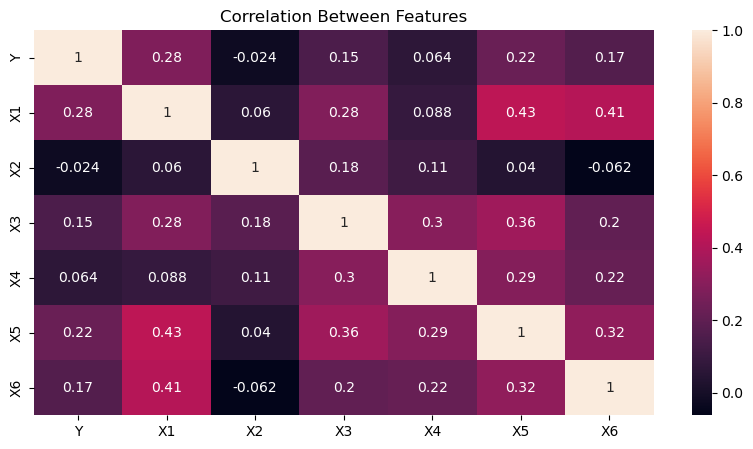

In [13]:
fix, ax = plt.subplots(figsize=(10,5))
sns.heatmap(data.corr(), annot = True).set(title='Correlation Between Features')
plt.show();

If we found two features to have a high correlation it would have been worth considering dropping one of those features. However, none of the features are correlated.

## Train Test Split

In [14]:
X = data.drop('Y', axis = 1)
y = data['Y']
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size = 0.2, random_state = 10)

In [15]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(100, 6) (100,)
(26, 6) (26,)


In [16]:
print('Percentage of dataset in Class 0: ', data[data['Y'] == 0].shape[0]/len(data)*100)
print('Percentage of dataset in Class 1: ', data[data['Y'] == 1].shape[0]/len(data)*100)

Percentage of dataset in Class 0:  45.23809523809524
Percentage of dataset in Class 1:  54.761904761904766


In [17]:
print('Percentage of Class 0 in training set:', np.count_nonzero(y_train == 0)/len(y_train)*100)
print('Percentage of Class 1 in training set:', np.count_nonzero(y_train == 1)/len(y_train)*100)

Percentage of Class 0 in training set: 48.0
Percentage of Class 1 in training set: 52.0


In [18]:
print('Percentage of Class 0 in validation set:', np.count_nonzero(y_test == 0)/len(y_test)*100)
print('Percentage of Class 1 in validation set:', np.count_nonzero(y_test == 1)/len(y_test)*100)

Percentage of Class 0 in validation set: 34.61538461538461
Percentage of Class 1 in validation set: 65.38461538461539


In [19]:
len(y_train)

100

## Dummy Model

In [20]:
dummy_model = DummyClassifier()
dummy_model.fit(X_train, y_train)
dummy_model.score(y_test, dummy_model.predict(X_test))

1.0

## Logistic Regression

In [21]:
base_lr = LogisticRegression(random_state = 10)
base_lr.fit(X_train, y_train)

y_pred = base_lr.predict(X_test)
training_score = base_lr.fit(X_train, y_train).score(X_train, y_train)
print('Accuracy Score: ', accuracy_score(y_test, y_pred))
print('Training Set score: ', training_score)

Accuracy Score:  0.6923076923076923
Training Set score:  0.59


In [22]:
param_grid = {'C': np.logspace(-3,3,7),
       'penalty': ['l1','l2'],
       'solver': ['lbfgs', 'liblinear']}
grid_lg = GridSearchCV(LogisticRegression(random_state = 10), param_grid, cv=10, scoring='accuracy')
grid_lg.fit(X_train, y_train)
print('Mean Cross Validation Score:' ,grid_lg.best_score_)
print('Parameters with Highest Cross Validation Score: ',grid_lg.best_params_)
print("Logistic Model's Best Accuracy: ", grid_lg.score(X_test,y_test))

Mean Cross Validation Score: 0.5499999999999999
Parameters with Highest Cross Validation Score:  {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
Logistic Model's Best Accuracy:  0.6923076923076923


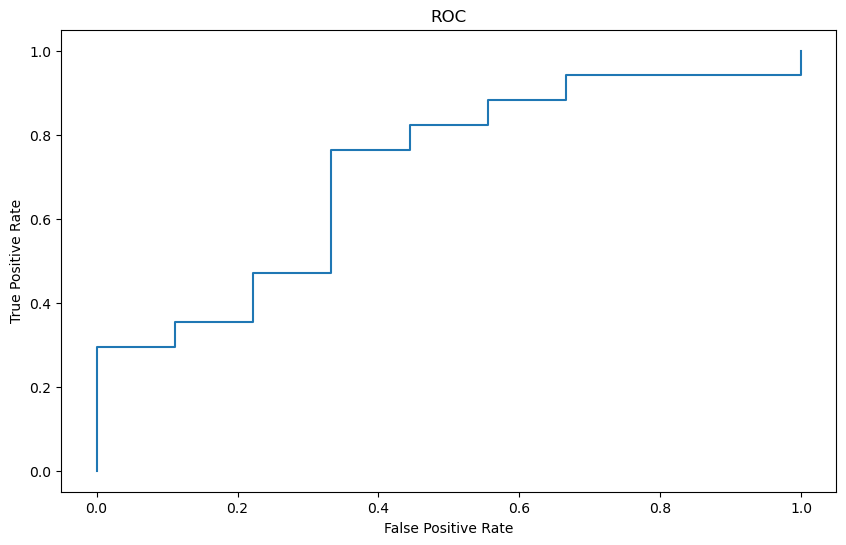

Area Under Curve:  0.7124183006535948


In [23]:
# fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
y_pred_prob = grid_lg.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc = roc_auc_score(y_test, y_pred_prob)
plt.figure(figsize=(10,6))
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.savefig('roc_best_random.png', bbox_inches = 'tight')
plt.show()
print('Area Under Curve: ',auc)

## KNearest Neighbors Classifier

In [24]:
base_knn = KNeighborsClassifier()
base_knn.fit(X_train, y_train)
y_pred = base_knn.predict(X_test)
training_score = base_knn.fit(X_train, y_train).score(X_train, y_train)
print('Accuracy Score: ', accuracy_score(y_test, y_pred))
print('Training Set Score: ', training_score)

Accuracy Score:  0.5
Training Set Score:  0.71


In [25]:
param_grid = {'leaf_size':list(range(1,15)), 
              'n_neighbors':list(range(1,15)), 
              'p':[1,2]} #p=1 is Manhatten Distance and p=2 is Euclidean Distances 
grid_knn = GridSearchCV(KNeighborsClassifier(), param_grid, cv=10, scoring='accuracy')
grid_knn.fit(X_train, y_train)
print('Mean Cross Validation Score:' ,grid_knn.best_score_)
print('Parameters with Highest Cross Validation Score: ',grid_knn.best_params_)
print("K Nearest Nieghbors Model's Best Accuracy: ", grid_knn.score(X_test,y_test))

Mean Cross Validation Score: 0.63
Parameters with Highest Cross Validation Score:  {'leaf_size': 1, 'n_neighbors': 14, 'p': 1}
K Nearest Nieghbors Model's Best Accuracy:  0.5769230769230769


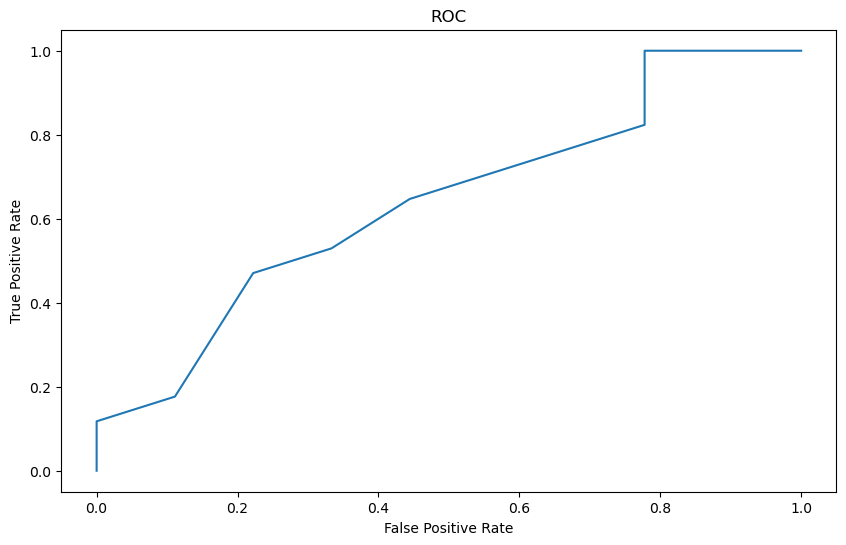

Area Under Curve:  0.6405228758169935


In [26]:
# fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
y_pred_prob = grid_knn.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc = roc_auc_score(y_test, y_pred_prob)
plt.figure(figsize=(10,6))
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.savefig('roc_best_random.png', bbox_inches = 'tight')
plt.show()
print('Area Under Curve: ',auc)

## Random Forest Classifier

In [27]:
base_rfc = RandomForestClassifier()
base_rfc.fit(X_train, y_train)
y_pred = base_rfc.predict(X_test)
training_score = base_rfc.fit(X_train, y_train).score(X_train, y_train)
print('Accuracy Score: ', accuracy_score(y_test, y_pred))
print('Training Set Score: ', training_score)

Accuracy Score:  0.5384615384615384
Training Set Score:  0.96


In [28]:
param_grid = {'n_estimators':np.arange(1,50), 
              'max_depth': np.arange(1,10),
             'criterion': ['gini', 'entropy']}
grid_rfc = GridSearchCV(RandomForestClassifier(random_state = 10), param_grid, cv=2, scoring = 'accuracy')
grid_rfc.fit(X_train, y_train)
print('Mean Cross Validation Score:' ,grid_rfc.best_score_)
print('Parameters with Highest Cross Validation Score: ',grid_rfc.best_params_)
print("Random Forest Classifier Model's Best Accuracy: ", grid_rfc.score(X_test,y_test))

Mean Cross Validation Score: 0.69
Parameters with Highest Cross Validation Score:  {'criterion': 'gini', 'max_depth': 4, 'n_estimators': 31}
Random Forest Classifier Model's Best Accuracy:  0.5769230769230769


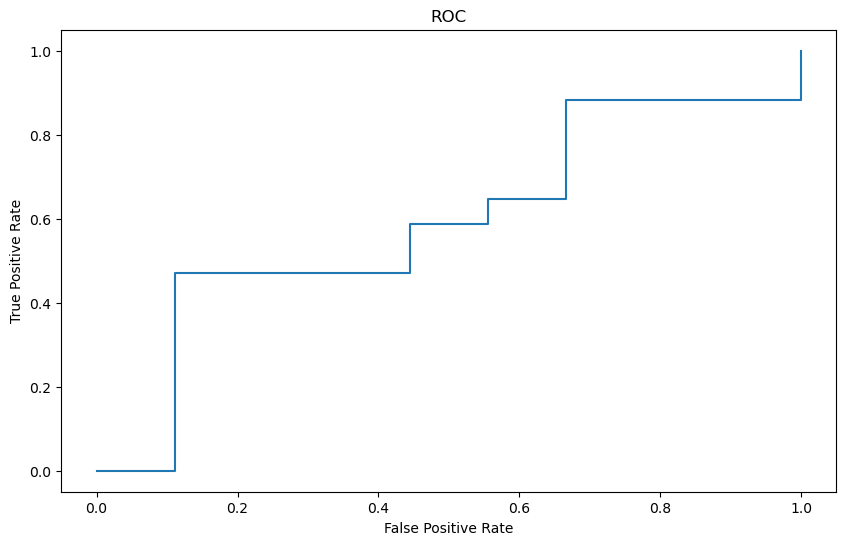

Area Under Curve:  0.5882352941176471


In [29]:
# fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
y_pred_prob = grid_rfc.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc = roc_auc_score(y_test, y_pred_prob)
plt.figure(figsize=(10,6))
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.savefig('roc_best_random.png', bbox_inches = 'tight')
plt.show()
print('Area Under Curve: ',auc)

### Feature Engineering with Random Forest Classifier

As one of our goals is the identify important features, let's have a look at the key features. Our goal is to try and exclude the 'less' imporant features and see if dropping these further imporves the model or not. 

Accuracy Score:  0.5384615384615384


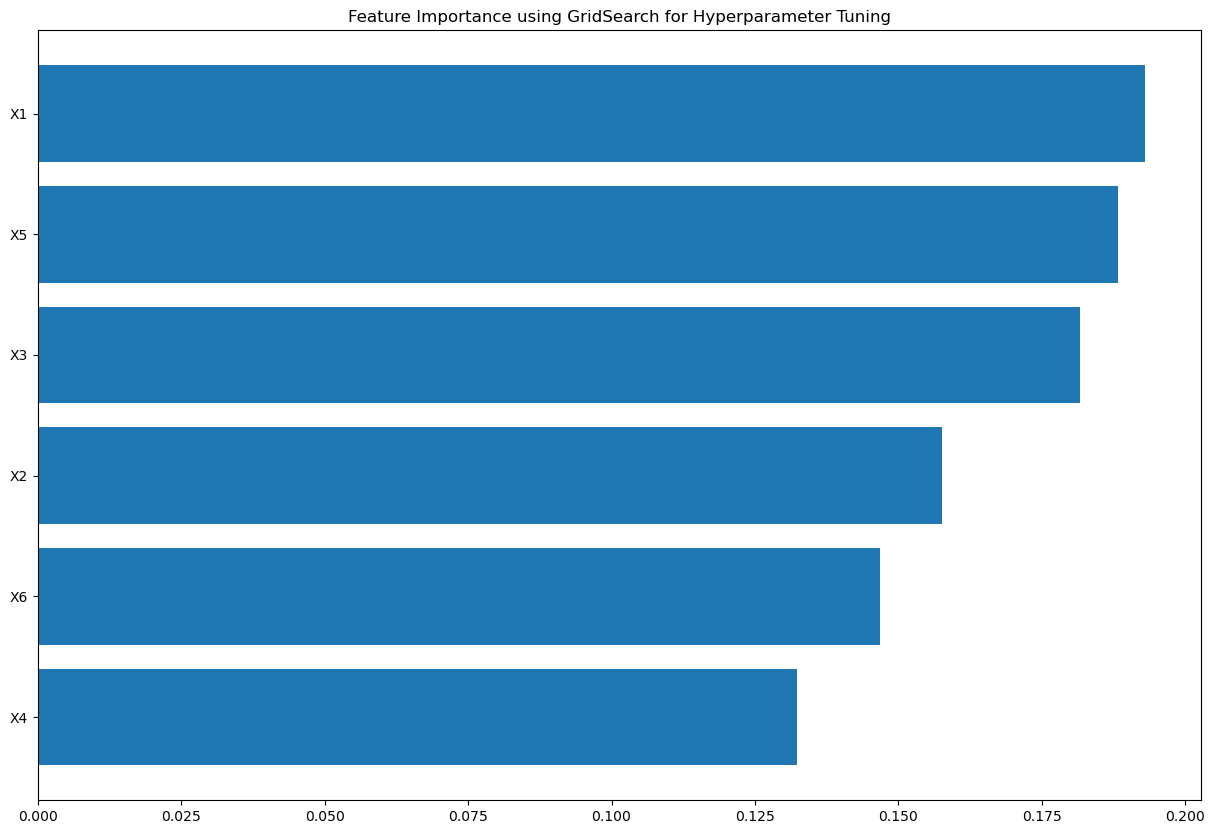

In [30]:
rfc = RandomForestClassifier(random_state = 10, criterion = 'entropy', max_depth = 5, n_estimators = 26)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
print('Accuracy Score: ', accuracy_score(y_test, y_pred))
sorted_importances = rfc.feature_importances_.argsort()
_ = plt.figure(figsize=(15,10))
_ = plt.barh(X.columns[sorted_importances], rfc.feature_importances_[sorted_importances])
_ = plt.title('Feature Importance using GridSearch for Hyperparameter Tuning')
_ = plt.savefig('feature_imp_grid.png', bbox_inches='tight')
plt.show()

In [31]:
top_3_features = data.drop(['X5', 'X2', 'X4'], axis = 1)
top_3_features
X_imp = top_3_features.drop('Y', axis = 1)
y_imp = top_3_features['Y']
Ximp_train, Ximp_test, yimp_train, yimp_test = train_test_split(X_imp.values, y_imp.values, test_size = 0.2, random_state = 10)
rfc = RandomForestClassifier(random_state = 10, criterion = 'entropy', max_depth = 5, n_estimators = 26)
model = rfc.fit(Ximp_train, yimp_train)
print('Training Set Score:', model.score(Ximp_train, yimp_train))
yimp_pred = model.predict(Ximp_test)
print('Accuracy Score', accuracy_score(yimp_test, yimp_pred))
print('Area Under the ROC: ', roc_auc_score(yimp_test, yimp_pred))

Training Set Score: 0.78
Accuracy Score 0.6538461538461539
Area Under the ROC:  0.6568627450980393


In [32]:
top_4_features = data.drop(['X4', 'X2'], axis = 1)
X_imp = top_4_features.drop('Y', axis = 1)
y_imp = top_4_features['Y']
Ximp_train, Ximp_test, yimp_train, yimp_test = train_test_split(X_imp.values, y_imp.values, test_size = 0.2, random_state = 10)
rfc = RandomForestClassifier(random_state = 10, criterion = 'entropy', max_depth = 5, n_estimators = 26)
model = rfc.fit(Ximp_train, yimp_train)
print('Training Set Score:', model.score(Ximp_train, yimp_train))
yimp_pred = model.predict(Ximp_test)
print('Accuracy Score', accuracy_score(yimp_test, yimp_pred))
print('Area Under the ROC: ', roc_auc_score(yimp_test, yimp_pred))

Training Set Score: 0.82
Accuracy Score 0.6538461538461539
Area Under the ROC:  0.6830065359477124


In [33]:
top_5_features = data.drop(['X4'], axis = 1)
X_imp = top_5_features.drop('Y', axis = 1)
y_imp = top_5_features['Y']
Ximp_train, Ximp_test, yimp_train, yimp_test = train_test_split(X_imp.values, y_imp.values, test_size = 0.2, random_state = 10)
rfc = RandomForestClassifier(random_state = 10, criterion = 'entropy', max_depth = 5, n_estimators = 26)
model = rfc.fit(Ximp_train, yimp_train)
print('Training Set Score:', model.score(Ximp_train, yimp_train))
yimp_pred = model.predict(Ximp_test)
print('Accuracy Score', accuracy_score(yimp_test, yimp_pred))
print('Area Under the ROC: ', roc_auc_score(yimp_test, yimp_pred))

Training Set Score: 0.86
Accuracy Score 0.5769230769230769
Area Under the ROC:  0.5718954248366014


## Support Vector Classifier

In [34]:
base_svc = SVC(random_state = 10)
base_svc.fit(X_train, y_train)
y_pred = base_svc.predict(X_test)
training_score = base_svc.fit(X_train, y_train).score(X_train, y_train)
print('Accuracy Score: ', accuracy_score(y_test, y_pred))
print('Training Set Score: ', training_score)

Accuracy Score:  0.5
Training Set Score:  0.71


In [35]:
param_grid = {'C': np.logspace(-3,3,7), 
              'gamma': [1,0.1,0.01,0.001,0.0001], 
              'kernel': ["linear", "poly", "rbf", "sigmoid"], 
             'probability': [True]} 
grid_svc = GridSearchCV(SVC(random_state = 10), param_grid, cv=2, scoring = 'accuracy')
grid_svc.fit(X_train, y_train)
print('Mean Cross Validation Score:' ,grid_svc.best_score_)
print('Parameters with Highest Cross Validation Score: ',grid_svc.best_params_)
print("Support Vector Classifier Model's Best Accuracy: ", grid_svc.score(X_test,y_test))

Mean Cross Validation Score: 0.62
Parameters with Highest Cross Validation Score:  {'C': 0.001, 'gamma': 0.1, 'kernel': 'poly', 'probability': True}
Support Vector Classifier Model's Best Accuracy:  0.6538461538461539


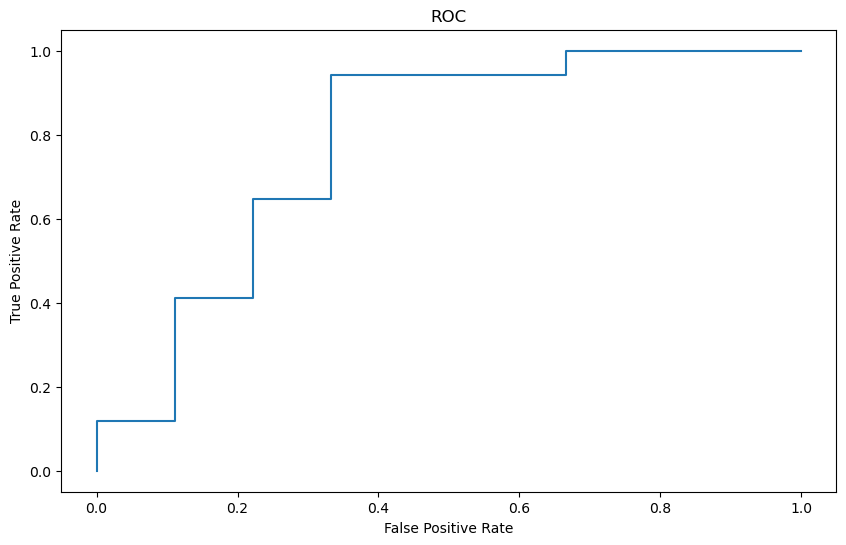

Area Under Curve:  0.7777777777777778


In [36]:
# fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
y_pred_prob = grid_svc.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc = roc_auc_score(y_test, y_pred_prob)
plt.figure(figsize=(10,6))
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.savefig('roc_best_random.png', bbox_inches = 'tight')
plt.show()
print('Area Under Curve: ',auc)

In [37]:
param_grid = {'C': np.logspace(-3,3,7), 
              'gamma': [1,0.1,0.01,0.001,0.0001], 
              'kernel': ["linear"], 
             'probability': [True]} 
grid_svc = GridSearchCV(SVC(random_state = 10), param_grid, cv=2, scoring = 'accuracy')
grid_svc.fit(X_train, y_train)
print('Mean Cross Validation Score:' ,grid_svc.best_score_)
print('Parameters with Highest Cross Validation Score: ',grid_svc.best_params_)
print("Support Vector Classifier Model's Best Accuracy: ", grid_svc.score(X_test,y_test))

Mean Cross Validation Score: 0.55
Parameters with Highest Cross Validation Score:  {'C': 0.1, 'gamma': 1, 'kernel': 'linear', 'probability': True}
Support Vector Classifier Model's Best Accuracy:  0.6923076923076923


#### Feature engineering with SVC

Error in training set:  0.54
Accuracy Score 0.5
Area Under the ROC:  0.5392156862745098


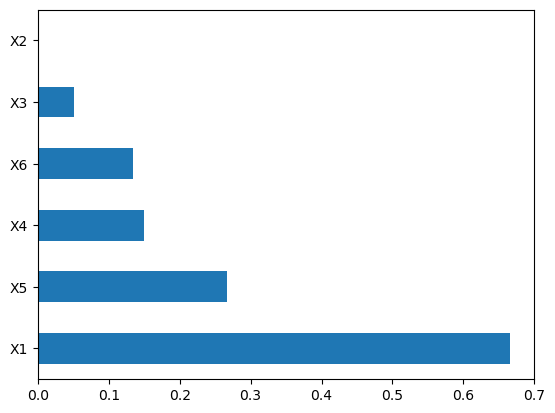

In [38]:
svc_linear_model = SVC(C = 0.1, gamma = 1, kernel = 'linear', probability = True)
model = svc_linear_model.fit(X_train, y_train)
predictions = model.predict(X_test)
print('Error in training set: ', model.score(X_train, y_train))
print('Accuracy Score', accuracy_score(y_test, y_pred))
print('Area Under the ROC: ', roc_auc_score(y_test, y_pred))
fig = pd.Series(abs(model.coef_[0]), index=X.columns).nlargest(10).plot(kind='barh')

In [39]:
top_2_features = data.drop(['X2', 'X3', 'X6', 'X4'], axis = 1)
top_2_features
X_imp = top_2_features.drop('Y', axis = 1)
y_imp = top_2_features['Y']
Ximp_train, Ximp_test, yimp_train, yimp_test = train_test_split(X_imp.values, y_imp.values, test_size = 0.2, random_state = 10)
svc = svc_linear_model = SVC(C = 0.1, gamma = 1, kernel = 'linear', probability = True)
model = svc.fit(Ximp_train, yimp_train)
print('Training Set Score:', model.score(Ximp_train, yimp_train))
yimp_pred = model.predict(Ximp_test)
print('Accuracy Score', accuracy_score(yimp_test, yimp_pred))
print('Area Under the ROC: ', roc_auc_score(yimp_test, yimp_pred))

Training Set Score: 0.55
Accuracy Score 0.6538461538461539
Area Under the ROC:  0.6830065359477124


In [40]:
top_features = data.drop(['X2', 'X3', 'X6', 'X4', 'X5'], axis = 1)
top_features
X_imp = top_features.drop('Y', axis = 1)
y_imp = top_features['Y']
Ximp_train, Ximp_test, yimp_train, yimp_test = train_test_split(X_imp.values, y_imp.values, test_size = 0.2, random_state = 10)
svc = svc_linear_model = SVC(C = 0.1, gamma = 1, kernel = 'linear', probability = True)
model = svc.fit(Ximp_train, yimp_train)
print('Training Set Score:', model.score(Ximp_train, yimp_train))
yimp_pred = model.predict(Ximp_test)
print('Accuracy Score', accuracy_score(yimp_test, yimp_pred))
print('Area Under the ROC: ', roc_auc_score(yimp_test, yimp_pred))

Training Set Score: 0.65
Accuracy Score 0.6538461538461539
Area Under the ROC:  0.6830065359477124


By dropping the features we do see a 

## Gradient Boosting Classifier

In [41]:
base_gbc = GradientBoostingClassifier()
base_gbc.fit(X_train, y_train)
y_pred = base_gbc.predict(X_test)
training_score = base_gbc.fit(X_train, y_train).score(X_train, y_train)
print('Accuracy Score: ',accuracy_score(y_test, y_pred))
print('Training Set Score: ', training_score)

Accuracy Score:  0.6538461538461539
Training Set Score:  0.93


In [42]:
param_grid = {"learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    "min_samples_split": np.linspace(0.1, 0.5, 12),
    "min_samples_leaf": np.linspace(0.1, 0.5, 12),
    "max_depth":[3,5,8],
    "max_features":["log2","sqrt"],
    "criterion": ["friedman_mse",  "mae"],
    "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95],
    "n_estimators":[10]
    }
grid_gbc = GridSearchCV(GradientBoostingClassifier(), param_grid, scoring = 'accuracy', cv = 2)
grid_gbc.fit(X_train, y_train)
print('Mean Cross Validation Score:' ,grid_gbc.best_score_)
print('Parameters with Highest Cross Validation Score: ', grid_gbc.best_params_)
print("Gradient Boosting Classifier Model's Best Accuracy: ", grid_gbc.score(X_test,y_test))

Mean Cross Validation Score: 0.71
Parameters with Highest Cross Validation Score:  {'criterion': 'mae', 'learning_rate': 0.15, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 0.1, 'min_samples_split': 0.390909090909091, 'n_estimators': 10, 'subsample': 0.95}
Gradient Boosting Classifier Model's Best Accuracy:  0.5769230769230769


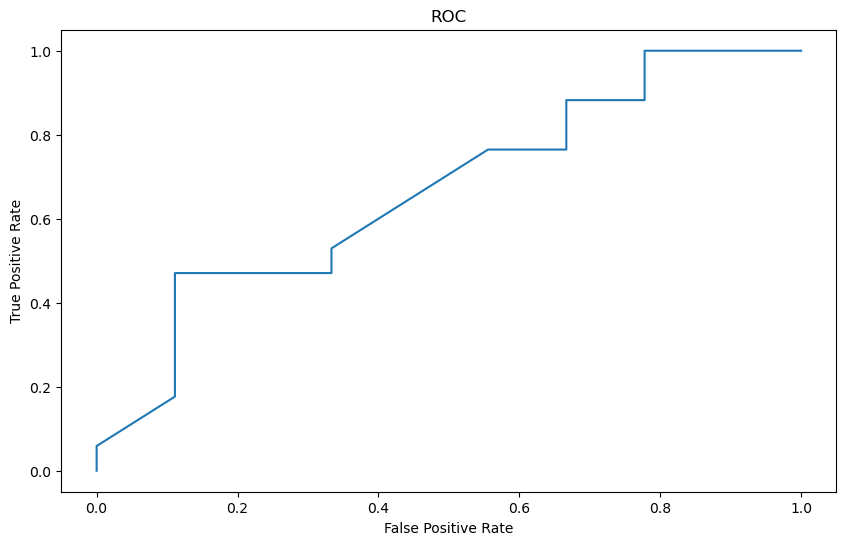

Area Under Curve:  0.6666666666666666


In [43]:
# fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
y_pred_prob = grid_gbc.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc = roc_auc_score(y_test, y_pred_prob)
plt.figure(figsize=(10,6))
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.savefig('roc_best_random.png', bbox_inches = 'tight')
plt.show()
print('Area Under Curve: ',auc)

Accuracy Score:  0.5769230769230769


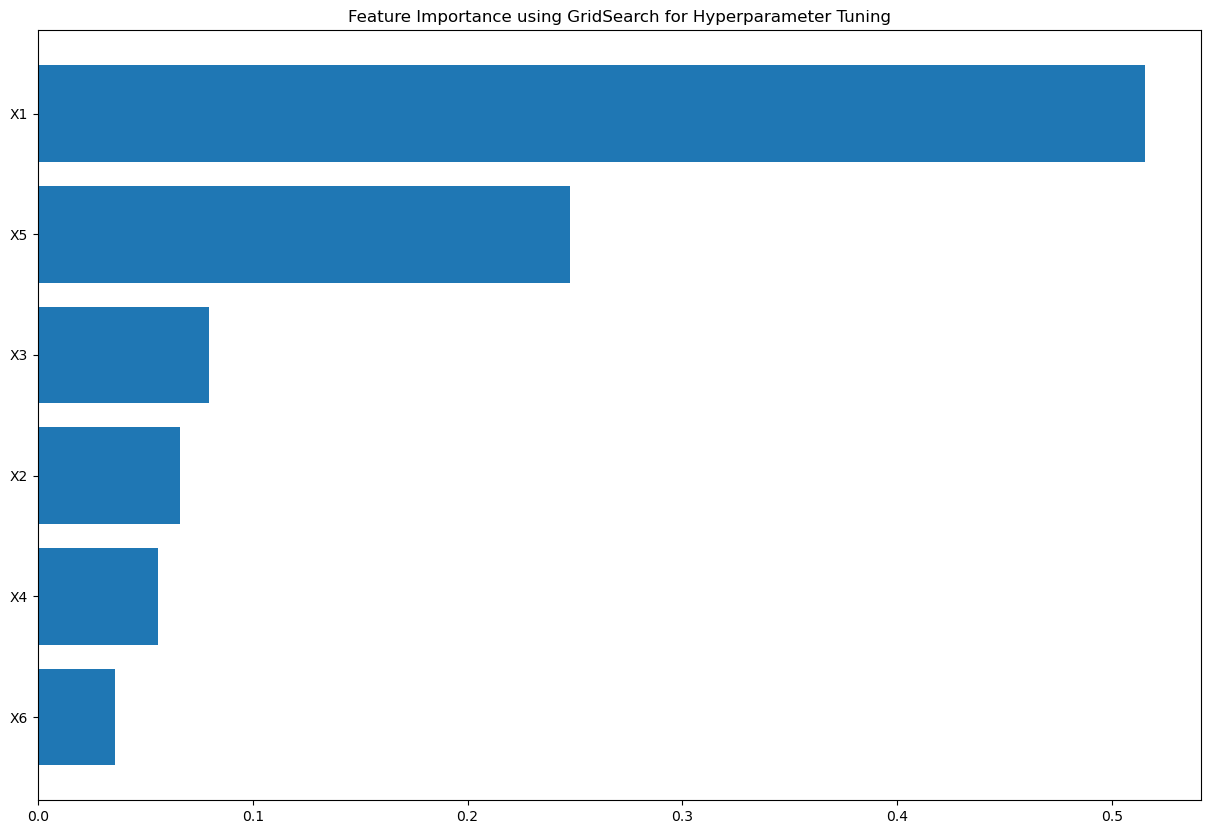

In [44]:
gbc = GradientBoostingClassifier( criterion = 'friedman_mse',
                                 learning_rate = 0.075,
                                 max_depth = 5,
                                 max_features = 'sqrt', 
                                 min_samples_leaf = 0.1,
                                 min_samples_split = 0.28181818181818186, 
                                 n_estimators = 10, 
                                 subsample = 0.95)
gbc.fit(X_train, y_train)
y_pred = gbc.predict(X_test)
print('Accuracy Score: ', accuracy_score(y_test, y_pred))
sorted_importances = gbc.feature_importances_.argsort()
_ = plt.figure(figsize=(15,10))
_ = plt.barh(X.columns[sorted_importances], gbc.feature_importances_[sorted_importances])
_ = plt.title('Feature Importance using GridSearch for Hyperparameter Tuning')
_ = plt.savefig('feature_imp_grid.png', bbox_inches='tight')
plt.show()

In [45]:
top_3_features = data.drop(['X2', 'X4', 'X3'], axis = 1)
top_3_features
X_imp = top_3_features.drop('Y', axis = 1)
y_imp = top_3_features['Y']
Ximp_train, Ximp_test, yimp_train, yimp_test = train_test_split(X_imp.values, y_imp.values, test_size = 0.2, random_state = 10)
gbc = GradientBoostingClassifier( criterion = 'friedman_mse',
                                 learning_rate = 0.075,
                                 max_depth = 5,
                                 max_features = 'sqrt', 
                                 min_samples_leaf = 0.1,
                                 min_samples_split = 0.28181818181818186, 
                                 n_estimators = 10, 
                                 subsample = 0.95)
model = gbc.fit(Ximp_train, yimp_train)
print('Training Set Score:', model.score(Ximp_train, yimp_train))
yimp_pred = model.predict(Ximp_test)
print('Accuracy Score', accuracy_score(yimp_test, yimp_pred))
print('Area Under the ROC: ', roc_auc_score(yimp_test, yimp_pred))

Training Set Score: 0.72
Accuracy Score 0.6153846153846154
Area Under the ROC:  0.6535947712418301


In [46]:
top_4_features = data.drop(['X2', 'X4'], axis = 1)
X_imp = top_4_features.drop('Y', axis = 1)
y_imp = top_4_features['Y']
Ximp_train, Ximp_test, yimp_train, yimp_test = train_test_split(X_imp.values, y_imp.values, test_size = 0.2, random_state = 10)
gbc = GradientBoostingClassifier( criterion = 'friedman_mse',
                                 learning_rate = 0.075,
                                 max_depth = 5,
                                 max_features = 'sqrt', 
                                 min_samples_leaf = 0.1,
                                 min_samples_split = 0.28181818181818186, 
                                 n_estimators = 10, 
                                 subsample = 0.95)
model = gbc.fit(Ximp_train, yimp_train)
print('Training Set Score:', model.score(Ximp_train, yimp_train))
yimp_pred = model.predict(Ximp_test)
print('Accuracy Score', accuracy_score(yimp_test, yimp_pred))
print('Area Under the ROC: ', roc_auc_score(yimp_test, yimp_pred))

Training Set Score: 0.69
Accuracy Score 0.6153846153846154
Area Under the ROC:  0.627450980392157


## XGBoost

In [47]:
base_xgb = XGBClassifier(random_state = 10)
base_xgb.fit(X_train, y_train)
y_pred = base_xgb.predict(X_test)
training_score = base_xgb.fit(X_train, y_train).score(X_train, y_train)
print('Accuracy Score: ', accuracy_score(y_test, y_pred))
print('Training Set Score: ', training_score)

Accuracy Score:  0.5384615384615384
Training Set Score:  0.93


In [48]:
param_grid =  {'objective':['binary:logistic'],
              'booster':['gbtree','gblinear'],
              'learning_rate': [0.1], 
              'max_depth': [7,10,15,20],
              'min_child_weight': [10,15,20,25],
              'colsample_bytree': [0.8, 0.9, 1],
              'n_estimators': [300,400,500,600],
              "reg_alpha"   : [0.5,0.2,1],
              "reg_lambda"  : [2,3,5],
              "gamma"       : [1,2,3]}
grid_xgb = GridSearchCV(XGBClassifier(), param_grid, scoring= 'accuracy', cv = 2)
grid_xgb.fit(X_train, y_train)
print('Mean Cross Validation Score:' ,grid_xgb.best_score_)
print('Parameters with Highest Cross Validation Score: ', grid_xgb.best_params_)
print("XGBoost Classifier Model's Best Accuracy: ", grid_xgb.score(X_test,y_test))

[18:39:05] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:39:05] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:39:06] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:39:06] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:39:06] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:39:06] WARNING: C:\Users\dev-admin\c

[18:39:14] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:39:15] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:39:15] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:39:15] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:39:16] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:39:16] WARNING: C:\Users\dev-admin\c

[18:39:26] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:39:27] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:39:27] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:39:27] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:39:27] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:39:27] WARNING: C:\Users\dev-admin\c

[18:39:37] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:39:38] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:39:38] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:39:38] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:39:38] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:39:38] WARNING: C:\Users\dev-admin\c

[18:39:46] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:39:46] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:39:46] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:39:47] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:39:47] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:39:47] WARNING: C:\Users\dev-admin\c

[18:39:58] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:39:58] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:39:58] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:39:58] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:39:58] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:39:58] WARNING: C:\Users\dev-admin\c

[18:40:06] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:40:07] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:40:07] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:40:07] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:40:07] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:40:07] WARNING: C:\Users\dev-admin\c

[18:40:16] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:40:16] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:40:16] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:40:17] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:40:17] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:40:17] WARNING: C:\Users\dev-admin\c

[18:40:25] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:40:25] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:40:25] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:40:26] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:40:26] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:40:26] WARNING: C:\Users\dev-admin\c

[18:40:31] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:40:31] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:40:32] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:40:32] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:40:32] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:40:32] WARNING: C:\Users\dev-admin\c

[18:40:39] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:40:39] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:40:39] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:40:39] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:40:39] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:40:39] WARNING: C:\Users\dev-admin\c

[18:40:45] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:40:45] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:40:45] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:40:46] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:40:46] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:40:46] WARNING: C:\Users\dev-admin\c

[18:40:53] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:40:53] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:40:53] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:40:53] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:40:54] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:40:54] WARNING: C:\Users\dev-admin\c

[18:41:02] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:41:02] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:41:02] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:41:02] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:41:03] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:41:03] WARNING: C:\Users\dev-admin\c

[18:41:08] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:41:08] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:41:09] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:41:09] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:41:09] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:41:09] WARNING: C:\Users\dev-admin\c

[18:41:16] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:41:16] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:41:17] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:41:17] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:41:17] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:41:17] WARNING: C:\Users\dev-admin\c

[18:41:24] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:41:24] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:41:25] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:41:25] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:41:25] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:41:25] WARNING: C:\Users\dev-admin\c

[18:41:34] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:41:35] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:41:35] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:41:35] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:41:35] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:41:35] WARNING: C:\Users\dev-admin\c

[18:41:44] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:41:44] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:41:44] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:41:44] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:41:45] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:41:45] WARNING: C:\Users\dev-admin\c

[18:41:50] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:41:50] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:41:51] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:41:51] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:41:51] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:41:51] WARNING: C:\Users\dev-admin\c

[18:42:00] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:42:00] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:42:00] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:42:00] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:42:01] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:42:01] WARNING: C:\Users\dev-admin\c

[18:42:08] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:42:08] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:42:09] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:42:09] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:42:09] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:42:10] WARNING: C:\Users\dev-admin\c

[18:42:19] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:42:19] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:42:19] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:42:20] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:42:20] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:42:20] WARNING: C:\Users\dev-admin\c

[18:42:29] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:42:30] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:42:30] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:42:30] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:42:31] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:42:31] WARNING: C:\Users\dev-admin\c

[18:42:38] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:42:38] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:42:39] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:42:39] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:42:39] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:42:40] WARNING: C:\Users\dev-admin\c

[18:42:54] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:42:54] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:42:55] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:42:55] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:42:55] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:42:56] WARNING: C:\Users\dev-admin\c

[18:43:08] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:43:09] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:43:09] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:43:09] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:43:09] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:43:10] WARNING: C:\Users\dev-admin\c

[18:43:19] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:43:19] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:43:19] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:43:19] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:43:19] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:43:20] WARNING: C:\Users\dev-admin\c

[18:43:30] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:43:31] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:43:31] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:43:31] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:43:31] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:43:32] WARNING: C:\Users\dev-admin\c

[18:43:40] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:43:40] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:43:40] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:43:41] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:43:41] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:43:41] WARNING: C:\Users\dev-admin\c

[18:43:51] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:43:52] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:43:52] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:43:52] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:43:52] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:43:52] WARNING: C:\Users\dev-admin\c

[18:44:01] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:44:01] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:44:01] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:44:02] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:44:02] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:44:02] WARNING: C:\Users\dev-admin\c

[18:44:09] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:44:09] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:44:09] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:44:09] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:44:09] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:44:09] WARNING: C:\Users\dev-admin\c

[18:44:16] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:44:16] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:44:16] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:44:16] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:44:17] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:44:17] WARNING: C:\Users\dev-admin\c

[18:44:22] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:44:22] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:44:23] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:44:23] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:44:23] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:44:23] WARNING: C:\Users\dev-admin\c

[18:44:33] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:44:34] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:44:34] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:44:34] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:44:34] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:44:34] WARNING: C:\Users\dev-admin\c

[18:44:42] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:44:42] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:44:43] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:44:43] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:44:43] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:44:43] WARNING: C:\Users\dev-admin\c

[18:44:53] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:44:53] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:44:53] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:44:53] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:44:54] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:44:54] WARNING: C:\Users\dev-admin\c

[18:45:02] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:45:02] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:45:03] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:45:03] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:45:03] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:45:04] WARNING: C:\Users\dev-admin\c

[18:45:11] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:45:11] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:45:11] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:45:11] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:45:12] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:45:13] WARNING: C:\Users\dev-admin\c

[18:45:23] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:45:23] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:45:23] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:45:23] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:45:23] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:45:23] WARNING: C:\Users\dev-admin\c

[18:45:31] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:45:32] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:45:32] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:45:32] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:45:32] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:45:33] WARNING: C:\Users\dev-admin\c

[18:45:40] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:45:40] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:45:40] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:45:40] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:45:41] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:45:41] WARNING: C:\Users\dev-admin\c

[18:45:47] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:45:47] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:45:47] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:45:48] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:45:48] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:45:48] WARNING: C:\Users\dev-admin\c

[18:45:57] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:45:58] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:45:58] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:45:58] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:45:59] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:45:59] WARNING: C:\Users\dev-admin\c

[18:46:10] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:46:10] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:46:10] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:46:10] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:46:10] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:46:10] WARNING: C:\Users\dev-admin\c

[18:46:15] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:46:15] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:46:16] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:46:16] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:46:16] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:46:16] WARNING: C:\Users\dev-admin\c

[18:46:21] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:46:21] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:46:21] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:46:21] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:46:21] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:46:21] WARNING: C:\Users\dev-admin\c

[18:46:27] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:46:27] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:46:28] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:46:28] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:46:28] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:46:28] WARNING: C:\Users\dev-admin\c

[18:46:32] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:46:32] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:46:32] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:46:33] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:46:33] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:46:33] WARNING: C:\Users\dev-admin\c

[18:46:43] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:46:43] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:46:44] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:46:44] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:46:44] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:46:44] WARNING: C:\Users\dev-admin\c

[18:46:53] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:46:53] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:46:54] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:46:54] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:46:54] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:46:54] WARNING: C:\Users\dev-admin\c

[18:47:03] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:47:03] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:47:03] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:47:03] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:47:04] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:47:04] WARNING: C:\Users\dev-admin\c

[18:47:13] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:47:14] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:47:14] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:47:15] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:47:15] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:47:15] WARNING: C:\Users\dev-admin\c

[18:47:22] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:47:22] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:47:22] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:47:23] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:47:23] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:47:23] WARNING: C:\Users\dev-admin\c

[18:47:30] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:47:30] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:47:30] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:47:30] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:47:31] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:47:31] WARNING: C:\Users\dev-admin\c

[18:47:36] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:47:36] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:47:36] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:47:37] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:47:37] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:47:37] WARNING: C:\Users\dev-admin\c

[18:47:43] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:47:43] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:47:43] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:47:43] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:47:43] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:47:44] WARNING: C:\Users\dev-admin\c

[18:47:51] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:47:51] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:47:52] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:47:52] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:47:52] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:47:52] WARNING: C:\Users\dev-admin\c

[18:47:57] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:47:58] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:47:58] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:47:58] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:47:58] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:47:58] WARNING: C:\Users\dev-admin\c

[18:48:06] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:48:06] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:48:06] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:48:06] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:48:06] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:48:07] WARNING: C:\Users\dev-admin\c

[18:48:13] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:48:13] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:48:13] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:48:14] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:48:14] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:48:14] WARNING: C:\Users\dev-admin\c

[18:48:20] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:48:20] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:48:20] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:48:21] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:48:21] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:48:21] WARNING: C:\Users\dev-admin\c

[18:48:29] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:48:30] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:48:30] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:48:30] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:48:30] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:48:30] WARNING: C:\Users\dev-admin\c

[18:48:35] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:48:35] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:48:36] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:48:36] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:48:36] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:48:36] WARNING: C:\Users\dev-admin\c

[18:48:43] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:48:43] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:48:43] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:48:44] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:48:44] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:48:44] WARNING: C:\Users\dev-admin\c

[18:48:50] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:48:50] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:48:50] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:48:50] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:48:50] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:48:51] WARNING: C:\Users\dev-admin\c

[18:48:56] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:48:56] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:48:56] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:48:56] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:48:56] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:48:56] WARNING: C:\Users\dev-admin\c

[18:49:03] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:49:03] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:49:03] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:49:03] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:49:03] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:49:04] WARNING: C:\Users\dev-admin\c

[18:49:09] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:49:09] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:49:09] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:49:10] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:49:10] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:49:10] WARNING: C:\Users\dev-admin\c

[18:49:23] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:49:23] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:49:23] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:49:23] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:49:24] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:49:24] WARNING: C:\Users\dev-admin\c

[18:49:30] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:49:30] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:49:30] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:49:30] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:49:31] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:49:31] WARNING: C:\Users\dev-admin\c

[18:49:40] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:49:40] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:49:41] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:49:41] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:49:41] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:49:41] WARNING: C:\Users\dev-admin\c

[18:49:53] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:49:53] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:49:54] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:49:54] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:49:54] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:49:54] WARNING: C:\Users\dev-admin\c

[18:49:59] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:49:59] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:49:59] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:49:59] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:49:59] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:49:59] WARNING: C:\Users\dev-admin\c

[18:50:07] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:50:07] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:50:07] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:50:07] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:50:08] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:50:09] WARNING: C:\Users\dev-admin\c

[18:50:18] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:50:18] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:50:18] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:50:19] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:50:19] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:50:19] WARNING: C:\Users\dev-admin\c

[18:50:28] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:50:28] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:50:28] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:50:29] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:50:29] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:50:29] WARNING: C:\Users\dev-admin\c

[18:50:39] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:50:39] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:50:40] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:50:40] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:50:40] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:50:40] WARNING: C:\Users\dev-admin\c

[18:50:47] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:50:47] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:50:48] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:50:48] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:50:48] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:50:48] WARNING: C:\Users\dev-admin\c

[18:51:01] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:51:01] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:51:01] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:51:01] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:51:01] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:51:02] WARNING: C:\Users\dev-admin\c

[18:51:10] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:51:10] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:51:11] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:51:11] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:51:11] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:51:12] WARNING: C:\Users\dev-admin\c

[18:51:21] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:51:21] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:51:21] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:51:21] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:51:22] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:51:22] WARNING: C:\Users\dev-admin\c

[18:51:31] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:51:31] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:51:31] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:51:31] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:51:31] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:51:31] WARNING: C:\Users\dev-admin\c

[18:51:40] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:51:40] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:51:40] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:51:41] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:51:41] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:51:41] WARNING: C:\Users\dev-admin\c

[18:51:49] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:51:49] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:51:49] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:51:49] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:51:49] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:51:49] WARNING: C:\Users\dev-admin\c

[18:51:56] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:51:57] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:51:57] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:51:57] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:51:57] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:51:58] WARNING: C:\Users\dev-admin\c

[18:52:09] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:52:10] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:52:11] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:52:12] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:52:12] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:52:12] WARNING: C:\Users\dev-admin\c

[18:52:25] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:52:25] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:52:26] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:52:26] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:52:26] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:52:26] WARNING: C:\Users\dev-admin\c

[18:52:35] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:52:35] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:52:35] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:52:35] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:52:36] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:52:36] WARNING: C:\Users\dev-admin\c

[18:52:49] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:52:49] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:52:49] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:52:49] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:52:50] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:52:50] WARNING: C:\Users\dev-admin\c

[18:53:03] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:53:03] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:53:03] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:53:04] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:53:04] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:53:05] WARNING: C:\Users\dev-admin\c

[18:53:13] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:53:13] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:53:13] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:53:13] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:53:13] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:53:14] WARNING: C:\Users\dev-admin\c

[18:53:25] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:53:25] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:53:25] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:53:25] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:53:25] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:53:26] WARNING: C:\Users\dev-admin\c

[18:53:35] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:53:35] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:53:35] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:53:35] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:53:35] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:53:36] WARNING: C:\Users\dev-admin\c

[18:53:46] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:53:46] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:53:46] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:53:46] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:53:46] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:53:46] WARNING: C:\Users\dev-admin\c

[18:53:58] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:53:58] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:53:59] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:53:59] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:53:59] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:54:01] WARNING: C:\Users\dev-admin\c

[18:54:09] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:54:10] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:54:10] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:54:10] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:54:10] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:54:10] WARNING: C:\Users\dev-admin\c

[18:54:18] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:54:18] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:54:18] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:54:19] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:54:19] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:54:19] WARNING: C:\Users\dev-admin\c

[18:54:24] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:54:24] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:54:24] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:54:25] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:54:25] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:54:25] WARNING: C:\Users\dev-admin\c

[18:54:32] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:54:32] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:54:32] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:54:32] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:54:32] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:54:32] WARNING: C:\Users\dev-admin\c

[18:54:39] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:54:39] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:54:39] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:54:39] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:54:40] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:54:40] WARNING: C:\Users\dev-admin\c

[18:54:46] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:54:46] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:54:46] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:54:46] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:54:46] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:54:47] WARNING: C:\Users\dev-admin\c

[18:54:55] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:54:55] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:54:55] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:54:55] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:54:55] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:54:55] WARNING: C:\Users\dev-admin\c

[18:55:01] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:55:01] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:55:01] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:55:02] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:55:02] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:55:02] WARNING: C:\Users\dev-admin\c

[18:55:09] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:55:09] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:55:10] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:55:10] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:55:10] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:55:10] WARNING: C:\Users\dev-admin\c

[18:55:17] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:55:17] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:55:17] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:55:17] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:55:17] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:55:18] WARNING: C:\Users\dev-admin\c

[18:55:24] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:55:24] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:55:24] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:55:24] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:55:24] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:55:25] WARNING: C:\Users\dev-admin\c

[18:55:31] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:55:31] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:55:32] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:55:32] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:55:32] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:55:32] WARNING: C:\Users\dev-admin\c

[18:55:40] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:55:40] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:55:40] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:55:40] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:55:41] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:55:41] WARNING: C:\Users\dev-admin\c

[18:55:49] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:55:49] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:55:49] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:55:49] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:55:50] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:55:50] WARNING: C:\Users\dev-admin\c

[18:55:58] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:55:58] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:55:58] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:55:59] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:55:59] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:55:59] WARNING: C:\Users\dev-admin\c

[18:56:05] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:56:05] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:56:05] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:56:05] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:56:06] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:56:06] WARNING: C:\Users\dev-admin\c

[18:56:13] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:56:13] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:56:14] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:56:14] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:56:14] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:56:14] WARNING: C:\Users\dev-admin\c

[18:56:20] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:56:20] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:56:21] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:56:21] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:56:21] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:56:21] WARNING: C:\Users\dev-admin\c

[18:56:27] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:56:27] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:56:27] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:56:28] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:56:28] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:56:28] WARNING: C:\Users\dev-admin\c

[18:56:38] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:56:38] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:56:38] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:56:38] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:56:39] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:56:39] WARNING: C:\Users\dev-admin\c

[18:56:45] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:56:45] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:56:45] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:56:45] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:56:45] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:56:46] WARNING: C:\Users\dev-admin\c

[18:56:53] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:56:53] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:56:53] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:56:54] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:56:54] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:56:54] WARNING: C:\Users\dev-admin\c

[18:57:00] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:57:00] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:57:00] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:57:01] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:57:01] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:57:01] WARNING: C:\Users\dev-admin\c

[18:57:07] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:57:07] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:57:07] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:57:07] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:57:07] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:57:07] WARNING: C:\Users\dev-admin\c

[18:57:16] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:57:16] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:57:16] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:57:16] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:57:17] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:57:17] WARNING: C:\Users\dev-admin\c

[18:57:23] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:57:23] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:57:23] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:57:23] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:57:24] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:57:24] WARNING: C:\Users\dev-admin\c

[18:57:30] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:57:30] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:57:30] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:57:31] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:57:31] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:57:31] WARNING: C:\Users\dev-admin\c

[18:57:47] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:57:48] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:57:49] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:57:50] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:57:50] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:57:50] WARNING: C:\Users\dev-admin\c

[18:58:02] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:58:02] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:58:02] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:58:03] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:58:03] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:58:03] WARNING: C:\Users\dev-admin\c

[18:58:10] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:58:11] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:58:11] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:58:11] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:58:11] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:58:11] WARNING: C:\Users\dev-admin\c

[18:58:16] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:58:17] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:58:17] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:58:17] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:58:17] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:58:17] WARNING: C:\Users\dev-admin\c

[18:58:30] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:58:30] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:58:30] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:58:31] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:58:32] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:58:32] WARNING: C:\Users\dev-admin\c

[18:58:42] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:58:42] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:58:42] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:58:42] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:58:42] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:58:43] WARNING: C:\Users\dev-admin\c

[18:58:50] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:58:50] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:58:50] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:58:50] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:58:51] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:58:51] WARNING: C:\Users\dev-admin\c

[18:58:58] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:58:58] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:58:59] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:58:59] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:58:59] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:58:59] WARNING: C:\Users\dev-admin\c

[18:59:04] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:59:04] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:59:04] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:59:04] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:59:04] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:59:04] WARNING: C:\Users\dev-admin\c

[18:59:10] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:59:10] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:59:10] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:59:10] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:59:11] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:59:11] WARNING: C:\Users\dev-admin\c

[18:59:18] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:59:19] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:59:19] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:59:19] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:59:20] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:59:20] WARNING: C:\Users\dev-admin\c

[18:59:26] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:59:26] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:59:27] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:59:27] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:59:27] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:59:27] WARNING: C:\Users\dev-admin\c

[18:59:34] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:59:34] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:59:35] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:59:35] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:59:35] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:59:35] WARNING: C:\Users\dev-admin\c

[18:59:40] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:59:40] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:59:40] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:59:40] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:59:40] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:59:41] WARNING: C:\Users\dev-admin\c

[18:59:46] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:59:46] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:59:46] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:59:46] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:59:47] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:59:47] WARNING: C:\Users\dev-admin\c

[18:59:52] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:59:52] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:59:52] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:59:52] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:59:53] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:59:53] WARNING: C:\Users\dev-admin\c

[18:59:57] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:59:58] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:59:58] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:59:58] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:59:58] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[18:59:58] WARNING: C:\Users\dev-admin\c

[19:00:08] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:00:08] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:00:09] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:00:09] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:00:09] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:00:09] WARNING: C:\Users\dev-admin\c

[19:00:15] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:00:16] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:00:16] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:00:16] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:00:16] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:00:16] WARNING: C:\Users\dev-admin\c

[19:00:24] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:00:24] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:00:24] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:00:24] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:00:24] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:00:24] WARNING: C:\Users\dev-admin\c

[19:00:32] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:00:33] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:00:33] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:00:33] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:00:33] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:00:33] WARNING: C:\Users\dev-admin\c

[19:00:40] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:00:40] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:00:40] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:00:40] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:00:40] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:00:40] WARNING: C:\Users\dev-admin\c

[19:00:48] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:00:49] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:00:49] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:00:49] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:00:49] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:00:49] WARNING: C:\Users\dev-admin\c

[19:00:59] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:00:59] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:00:59] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:00:59] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:00:59] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:01:00] WARNING: C:\Users\dev-admin\c

[19:01:06] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:01:06] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:01:06] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:01:06] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:01:07] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:01:07] WARNING: C:\Users\dev-admin\c

[19:01:13] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:01:13] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:01:13] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:01:13] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:01:14] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:01:14] WARNING: C:\Users\dev-admin\c

[19:01:21] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:01:21] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:01:22] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:01:22] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:01:22] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:01:22] WARNING: C:\Users\dev-admin\c

[19:01:29] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:01:29] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:01:29] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:01:30] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:01:30] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:01:30] WARNING: C:\Users\dev-admin\c

[19:01:35] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:01:35] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:01:36] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:01:36] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:01:36] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:01:36] WARNING: C:\Users\dev-admin\c

[19:01:50] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:01:50] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:01:50] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:01:50] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:01:51] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:01:51] WARNING: C:\Users\dev-admin\c

[19:01:59] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:01:59] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:01:59] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:02:00] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:02:00] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:02:00] WARNING: C:\Users\dev-admin\c

[19:02:08] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:02:08] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:02:09] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:02:09] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:02:09] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:02:09] WARNING: C:\Users\dev-admin\c

[19:02:17] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:02:17] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:02:17] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:02:17] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:02:17] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:02:17] WARNING: C:\Users\dev-admin\c

[19:02:23] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:02:23] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:02:24] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:02:24] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:02:24] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:02:24] WARNING: C:\Users\dev-admin\c

[19:02:30] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:02:30] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:02:30] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:02:30] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:02:30] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:02:30] WARNING: C:\Users\dev-admin\c

[19:02:36] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:02:36] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:02:36] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:02:37] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:02:37] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:02:37] WARNING: C:\Users\dev-admin\c

[19:02:43] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:02:43] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:02:43] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:02:43] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:02:44] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:02:44] WARNING: C:\Users\dev-admin\c

[19:02:53] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:02:53] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:02:53] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:02:53] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:02:53] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:02:54] WARNING: C:\Users\dev-admin\c

[19:03:00] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:03:00] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:03:00] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:03:00] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:03:01] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:03:01] WARNING: C:\Users\dev-admin\c

[19:03:06] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:03:07] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:03:07] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:03:07] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:03:07] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:03:07] WARNING: C:\Users\dev-admin\c

[19:03:13] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:03:14] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:03:14] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:03:14] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:03:14] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:03:14] WARNING: C:\Users\dev-admin\c

[19:03:19] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:03:19] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:03:19] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:03:19] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:03:19] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:03:20] WARNING: C:\Users\dev-admin\c

[19:03:26] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:03:27] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:03:27] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:03:27] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:03:27] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:03:27] WARNING: C:\Users\dev-admin\c

[19:03:34] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:03:34] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:03:34] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:03:34] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:03:34] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:03:34] WARNING: C:\Users\dev-admin\c

[19:03:40] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:03:40] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:03:40] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:03:41] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:03:41] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:03:41] WARNING: C:\Users\dev-admin\c

[19:03:47] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:03:48] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:03:48] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:03:48] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:03:48] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:03:48] WARNING: C:\Users\dev-admin\c

[19:03:54] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:03:55] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:03:57] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:03:57] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:03:57] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:03:57] WARNING: C:\Users\dev-admin\c

[19:04:19] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:04:19] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:04:19] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:04:19] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:04:19] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:04:20] WARNING: C:\Users\dev-admin\c

[19:04:29] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:04:30] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:04:30] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:04:30] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:04:30] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:04:31] WARNING: C:\Users\dev-admin\c

[19:04:41] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:04:41] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:04:42] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:04:42] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:04:42] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:04:43] WARNING: C:\Users\dev-admin\c

[19:05:04] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:05:05] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:05:05] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:05:06] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:05:06] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:05:06] WARNING: C:\Users\dev-admin\c

[19:05:13] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:05:14] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:05:14] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:05:14] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:05:15] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:05:15] WARNING: C:\Users\dev-admin\c

[19:05:24] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:05:24] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:05:24] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:05:24] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:05:24] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:05:25] WARNING: C:\Users\dev-admin\c

[19:05:31] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:05:31] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:05:32] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:05:32] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:05:32] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:05:32] WARNING: C:\Users\dev-admin\c

[19:05:43] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:05:43] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:05:43] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:05:43] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:05:43] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:05:44] WARNING: C:\Users\dev-admin\c

[19:05:56] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:05:56] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:05:56] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:05:56] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:05:56] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:05:56] WARNING: C:\Users\dev-admin\c

[19:06:03] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:06:03] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:06:03] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:06:04] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:06:04] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:06:04] WARNING: C:\Users\dev-admin\c

[19:06:12] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:06:12] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:06:12] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:06:12] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:06:12] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:06:12] WARNING: C:\Users\dev-admin\c

[19:06:22] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:06:22] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:06:22] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:06:22] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:06:22] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:06:23] WARNING: C:\Users\dev-admin\c

[19:06:29] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:06:29] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:06:29] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:06:29] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:06:29] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:06:30] WARNING: C:\Users\dev-admin\c

[19:06:39] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:06:39] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:06:39] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:06:39] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:06:40] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:06:40] WARNING: C:\Users\dev-admin\c

[19:06:45] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:06:45] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:06:46] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:06:46] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:06:46] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:06:47] WARNING: C:\Users\dev-admin\c

[19:06:56] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:06:57] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:06:57] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:06:57] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:06:57] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:06:57] WARNING: C:\Users\dev-admin\c

[19:07:06] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:07:07] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:07:07] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:07:07] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:07:07] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:07:08] WARNING: C:\Users\dev-admin\c

[19:07:15] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:07:16] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:07:16] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:07:16] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:07:16] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:07:16] WARNING: C:\Users\dev-admin\c

[19:07:31] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:07:31] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:07:31] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:07:32] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:07:32] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:07:32] WARNING: C:\Users\dev-admin\c

[19:07:51] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:07:52] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:08:00] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:08:01] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:08:02] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:08:03] WARNING: C:\Users\dev-admin\c

[19:08:23] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:08:23] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:08:23] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:08:23] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:08:23] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:08:24] WARNING: C:\Users\dev-admin\c

[19:08:33] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:08:33] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:08:33] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:08:34] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:08:34] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:08:34] WARNING: C:\Users\dev-admin\c

[19:08:40] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:08:40] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:08:40] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:08:40] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:08:40] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:08:41] WARNING: C:\Users\dev-admin\c

[19:08:48] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:08:49] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:08:49] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:08:49] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:08:49] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:08:50] WARNING: C:\Users\dev-admin\c

[19:08:56] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:08:56] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:08:56] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:08:56] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:08:56] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:08:56] WARNING: C:\Users\dev-admin\c

[19:09:06] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:09:06] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:09:07] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:09:07] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:09:07] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:09:07] WARNING: C:\Users\dev-admin\c

[19:09:20] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:09:20] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:09:20] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:09:20] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:09:20] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:09:21] WARNING: C:\Users\dev-admin\c

[19:09:27] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:09:27] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:09:28] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:09:28] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:09:28] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:09:28] WARNING: C:\Users\dev-admin\c

[19:09:35] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:09:35] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:09:35] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:09:35] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:09:35] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:09:36] WARNING: C:\Users\dev-admin\c

[19:09:41] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:09:41] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:09:41] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:09:42] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:09:42] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:09:42] WARNING: C:\Users\dev-admin\c

[19:09:49] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:09:49] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:09:49] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:09:50] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:09:50] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:09:50] WARNING: C:\Users\dev-admin\c

[19:09:56] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:09:56] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:09:57] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:09:57] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:09:57] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:09:58] WARNING: C:\Users\dev-admin\c

[19:10:12] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:10:12] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:10:14] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:10:14] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:10:15] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:10:15] WARNING: C:\Users\dev-admin\c

[19:10:32] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:10:32] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:10:32] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:10:32] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:10:33] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:10:33] WARNING: C:\Users\dev-admin\c

[19:10:43] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:10:43] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:10:44] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:10:44] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:10:44] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:10:44] WARNING: C:\Users\dev-admin\c

[19:10:55] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:10:55] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:10:55] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:10:56] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:10:56] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:10:56] WARNING: C:\Users\dev-admin\c

[19:11:04] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:11:04] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:11:05] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:11:05] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:11:05] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:11:06] WARNING: C:\Users\dev-admin\c

[19:11:13] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:11:14] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:11:14] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:11:14] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:11:14] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:11:14] WARNING: C:\Users\dev-admin\c

[19:11:21] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:11:21] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:11:21] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:11:21] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:11:21] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:11:21] WARNING: C:\Users\dev-admin\c

[19:11:26] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:11:26] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:11:26] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:11:26] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:11:26] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:11:26] WARNING: C:\Users\dev-admin\c

[19:11:32] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:11:32] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:11:32] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:11:32] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:11:32] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:11:33] WARNING: C:\Users\dev-admin\c

[19:11:38] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:11:38] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:11:38] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:11:38] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:11:38] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:11:38] WARNING: C:\Users\dev-admin\c

[19:11:44] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:11:44] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:11:44] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:11:44] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:11:44] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:11:44] WARNING: C:\Users\dev-admin\c

[19:11:50] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:11:50] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:11:51] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:11:51] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:11:51] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:11:51] WARNING: C:\Users\dev-admin\c

[19:11:55] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:11:55] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:11:55] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:11:55] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:11:55] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:11:56] WARNING: C:\Users\dev-admin\c

[19:12:01] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:12:01] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:12:01] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:12:01] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:12:01] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:12:02] WARNING: C:\Users\dev-admin\c

[19:12:06] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:12:07] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:12:07] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:12:07] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:12:07] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:12:07] WARNING: C:\Users\dev-admin\c

[19:12:12] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:12:12] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:12:12] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:12:12] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:12:12] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:12:12] WARNING: C:\Users\dev-admin\c

[19:12:20] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:12:20] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:12:20] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:12:20] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:12:20] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:12:20] WARNING: C:\Users\dev-admin\c

[19:12:26] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:12:26] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:12:26] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:12:26] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:12:27] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:12:27] WARNING: C:\Users\dev-admin\c

[19:12:33] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:12:33] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:12:33] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:12:33] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:12:33] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:12:33] WARNING: C:\Users\dev-admin\c

[19:12:39] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:12:39] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:12:39] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:12:39] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:12:39] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:12:40] WARNING: C:\Users\dev-admin\c

[19:12:44] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:12:44] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:12:44] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:12:44] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:12:45] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:12:45] WARNING: C:\Users\dev-admin\c

[19:12:51] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:12:51] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:12:52] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:12:52] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:12:52] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:12:52] WARNING: C:\Users\dev-admin\c

[19:12:59] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:12:59] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:12:59] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:12:59] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:12:59] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:12:59] WARNING: C:\Users\dev-admin\c

[19:13:05] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:13:05] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:13:05] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:13:05] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:13:06] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:13:06] WARNING: C:\Users\dev-admin\c

[19:13:11] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:13:11] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:13:11] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:13:12] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:13:12] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:13:12] WARNING: C:\Users\dev-admin\c

[19:13:17] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:13:17] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:13:17] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:13:18] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:13:18] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:13:18] WARNING: C:\Users\dev-admin\c

[19:13:25] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:13:25] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:13:25] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:13:26] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:13:26] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:13:26] WARNING: C:\Users\dev-admin\c

[19:13:31] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:13:31] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:13:32] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:13:32] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:13:32] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:13:32] WARNING: C:\Users\dev-admin\c

[19:13:39] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:13:39] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:13:39] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:13:39] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:13:39] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:13:39] WARNING: C:\Users\dev-admin\c

[19:13:46] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:13:46] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:13:46] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:13:46] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:13:47] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:13:47] WARNING: C:\Users\dev-admin\c

[19:13:55] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:13:56] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:13:56] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:13:56] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:13:57] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:13:57] WARNING: C:\Users\dev-admin\c

[19:14:04] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:14:04] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:14:04] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:14:04] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:14:04] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:14:04] WARNING: C:\Users\dev-admin\c

[19:14:09] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:14:09] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:14:09] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:14:09] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:14:09] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:14:09] WARNING: C:\Users\dev-admin\c

[19:14:14] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:14:14] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:14:15] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:14:15] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:14:15] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:14:15] WARNING: C:\Users\dev-admin\c

[19:14:21] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:14:21] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:14:21] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:14:21] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:14:22] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:14:22] WARNING: C:\Users\dev-admin\c

[19:14:26] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:14:26] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:14:26] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:14:27] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:14:27] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[19:14:27] WARNING: C:\Users\dev-admin\c

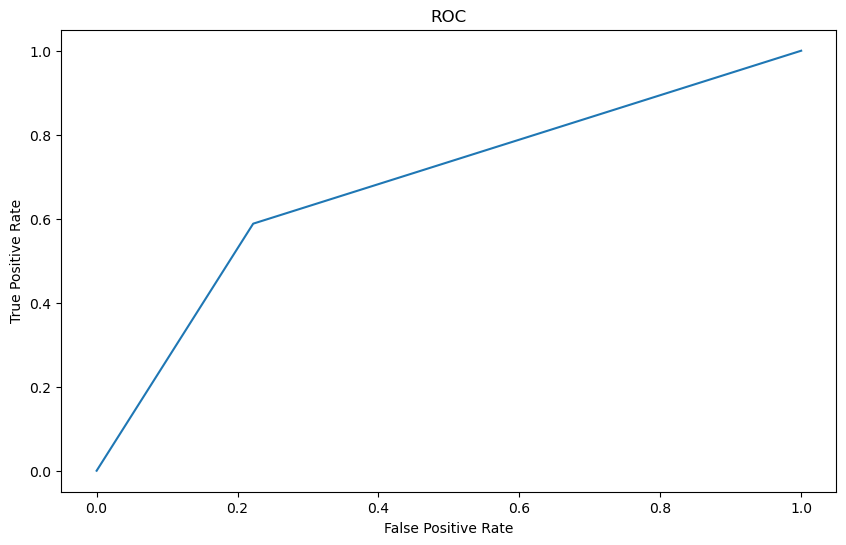

Area Under Curve:  0.6830065359477124


In [49]:
# fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
y_pred_prob = grid_xgb.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc = roc_auc_score(y_test, y_pred_prob)
plt.figure(figsize=(10,6))
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.savefig('roc_best_random.png', bbox_inches = 'tight')
plt.show()
print('Area Under Curve: ',auc)

Accuracy Score:  0.6538461538461539


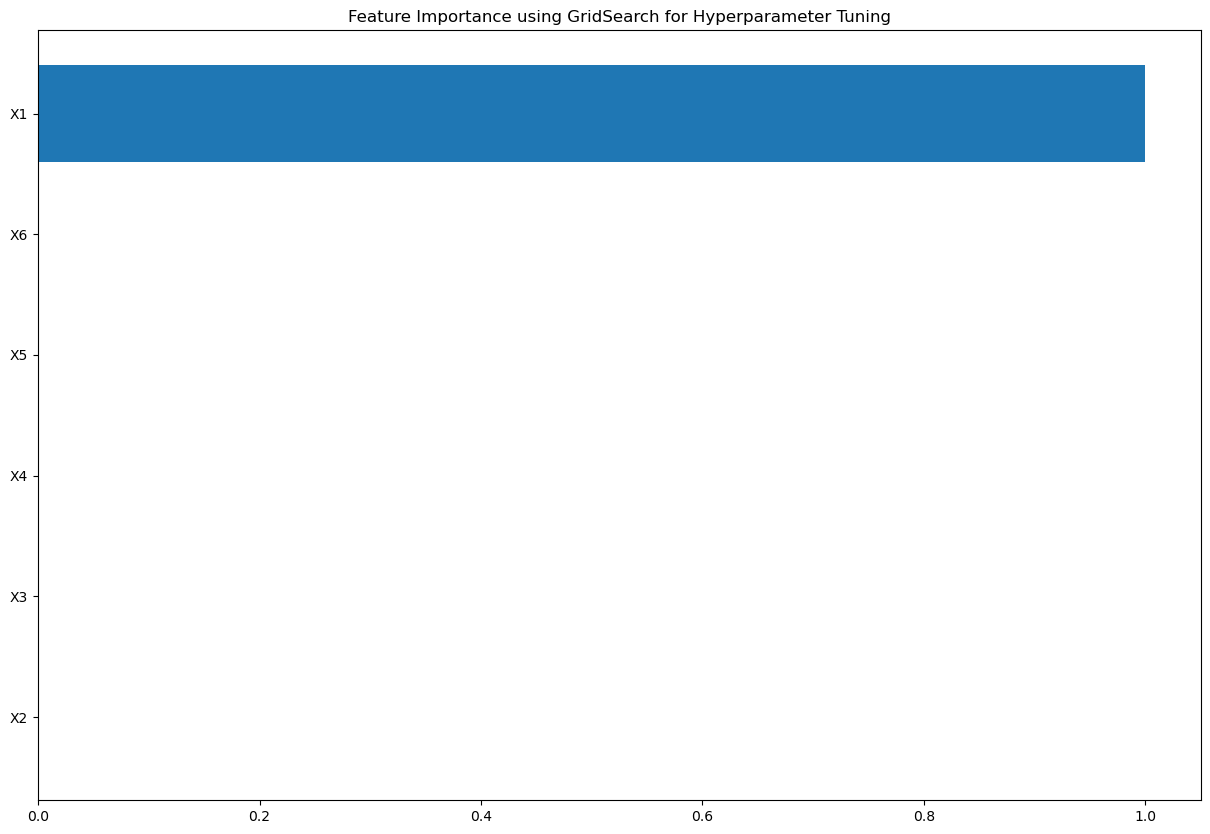

In [50]:
xgb = XGBClassifier( booster = 'gbtree', 
                    colsample_bytree = 0.8, 
                    gamma = 1, 
                    learning_rate = 0.1, 
                    max_depth = 7, 
                    min_child_weight = 10, 
                    n_estimators = 300,
                    objective = 'binary:logistic', 
                    reg_alpha = 0.5, 
                    reg_lambda = 25)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
print('Accuracy Score: ', accuracy_score(y_test, y_pred))
sorted_importances = xgb.feature_importances_.argsort()
_ = plt.figure(figsize=(15,10))
_ = plt.barh(X.columns[sorted_importances], xgb.feature_importances_[sorted_importances])
_ = plt.title('Feature Importance using GridSearch for Hyperparameter Tuning')
_ = plt.savefig('feature_imp_grid.png', bbox_inches='tight')
plt.show()

In [51]:
top_features = data.drop(['X2', 'X4', 'X3', 'X6', 'X5'], axis = 1)
X_imp = top_features.drop('Y', axis = 1)
y_imp = top_features['Y']
Ximp_train, Ximp_test, yimp_train, yimp_test = train_test_split(X_imp.values, y_imp.values, test_size = 0.2, random_state = 10)
xgb = XGBClassifier( booster = 'gbtree', 
                    colsample_bytree = 0.8, 
                    gamma = 1, 
                    learning_rate = 0.1, 
                    max_depth = 7, 
                    min_child_weight = 10, 
                    n_estimators = 300,
                    objective = 'binary:logistic', 
                    reg_alpha = 0.5, 
                    reg_lambda = 25)
model = xgb.fit(Ximp_train, yimp_train)
print('Training Set Score:', model.score(Ximp_train, yimp_train))
yimp_pred = model.predict(Ximp_test)
print('Accuracy Score', accuracy_score(yimp_test, yimp_pred))
print('Area Under the ROC: ', roc_auc_score(yimp_test, yimp_pred))

Training Set Score: 0.65
Accuracy Score 0.6538461538461539
Area Under the ROC:  0.6830065359477124


## Stacked Classifiers

In [52]:
from mlxtend.classifier import StackingCVClassifier

ModuleNotFoundError: No module named 'mlxtend'

### Base Model

In [ ]:
classifier1 = KNeighborsClassifier()
classifier2 = XGBClassifier(random_state = 10)
classifier3 = SVC(random_state = 10)
meta_classifier = LogisticRegression(random_state = 10)

In [ ]:
stacking_classifier = StackingCVClassifier(classifiers = [classifier1, classifier2, classifier3], 
                                          meta_classifier= meta_classifier, 
                                          random_state = 10)

In [ ]:
stacking_classifier.fit(X_train, y_train)
y_pred = stacking_classifier.predict(X_test)
print('\n Accuracy Score of Base Model: ', accuracy_score(y_test, y_pred))
print('\n')
stacking_classifier = StackingCVClassifier(classifiers = [classifier1, classifier2, classifier3], 
                                          meta_classifier= meta_classifier, 
                                          random_state = 10)
print('\n Training Set Score: ', stacking_classifier.fit(X, y).score(X,y))

### Hypertuning Parameters for Stacked Model

In [ ]:
classifier1_tuned = KNeighborsClassifier(n_neighbors= 1, p= 1, leaf_size = 2)
classifier2_tuned = XGBClassifier(booster = 'gbtree', 
                    colsample_bytree = 0.8, 
                    gamma = 1, 
                    learning_rate = 0.1, 
                    max_depth = 7, 
                    min_child_weight = 10, 
                    n_estimators = 300,
                    objective = 'binary:logistic', 
                    reg_alpha = 0.5, 
                    reg_lambda = 25)
classifier3_tuned = SVC(C = 0.001, gamma = 0.1, kernel = 'poly', probability = True, random_state = 10)
meta_classifier = LogisticRegression(random_state = 10)

In [ ]:
stacking_classifier_tuned = StackingCVClassifier(classifiers = [classifier1_tuned, classifier2_tuned, classifier3_tuned], 
                                          meta_classifier= meta_classifier, 
                                          random_state = 10)
params = {'meta_classifier__C': [0.1, 10], 
         'meta_classifier__penalty': ['l1','l2'],
         'meta_classifier__solver': ['lbfgs', 'liblinear']}

grid = GridSearchCV(estimator = stacking_classifier_tuned, 
                   param_grid = params, 
                   cv=5, 
                   refit = True)
grid.fit(X_train, y_train)
print("\n")
print('Mean Cross Validation Score:' ,grid.best_score_)
print('Parameters with Highest Cross Validation Score: ', grid.best_params_)
print("Stacking Classifier Model's Best Accuracy: ", grid.score(X_test,y_test))

### Final Model

In [ ]:
classifier1_tuned = KNeighborsClassifier(n_neighbors= 1, p= 1, leaf_size = 2)
classifier2_tuned = XGBClassifier(booster = 'gbtree', 
                    colsample_bytree = 0.8, 
                    gamma = 1, 
                    learning_rate = 0.1, 
                    max_depth = 7, 
                    min_child_weight = 10, 
                    n_estimators = 300,
                    objective = 'binary:logistic', 
                    reg_alpha = 0.5, 
                    reg_lambda = 25)
classifier3_tuned = SVC(C = 0.001, gamma = 0.1, kernel = 'poly', probability = True, random_state = 10)
meta_classifier = LogisticRegression(random_state = 10, C = 0.1, penalty = 'l2', solver = 'lbfgs')

stacking_classifier_tuned = StackingCVClassifier(classifiers = [classifier1_tuned, classifier2_tuned, classifier3_tuned], 
                                          meta_classifier= meta_classifier, 
                                          random_state = 10)
stacking_classifier.fit(X,y).score(X,y)

## Conclusions
The most important features: X1 and X5
Accuracy of final model : 86.5%

Whilst the stacked model reached an accuracy of 86.5%, and therefore, meets the success criteria, I would recommend that the area under the Receiver Operating Characteristic Curve is a better metric. This is because the AUC examines a models performance over varying threhold values. In this case, as we only have 126 datapoints, and with a 80:20 split of training and testing datasets, we have only 26 datapoints in the dataset. This means, an incorrect prediction in the very samll testing set will be penalised quite heavily. I noticed this as the accuracy scores, even with hypertuned parameters hovered around 69%. The advantage of using the AUC as the metric of choice is I would recommend we use the hypertuned support vector classifier model, as this has a highest AUC and is far simpler model than the stacked model. 

### Improvements to the Survey
There were no missing data in the dataset which is quite spurious. It would be interesting to know how many people didn't reply to the survey- sometimes a lack of reply can be quite useful as well. 

With this in mind, we can see for X1: 'My order was delivered on time' there are no ratings of 1 for happy customers, and neither happy nor unsatisfied customers voted for a rating of 2. This could mean that the delivery time is relatively great, but it could mean there's not enough representation of each type of customers. For example, maybe there are unhappy customers who aren't actually filling out the survey and are also stopping use of services. In order to determine this, we need to look at how many customers are recurrent users, and what their responses were versus customers who stopped using the companies services. In addition, another important feature that was identified is X6: 'The app makes ordering easy for me'. It's noteworthy that a large proportion of unhappy customers gave this a rating of 3 whilst happy customers did mostly give this feature high ratings. So, additional information would be useful to address the problems unhappy customers are facing. One possible information could be devices/operating systems the users are openning the app on- this could help identify if there are specific OS users that are facing problems or not. 

Furthermore, there are quite a few cusotmers, both happy and unhappy customers, who were disappointed with the contents of their order. However, the vagueness of the question means we don't know what they were actually unhappy with. Were it the actual products or the products didn't match what they were advertised to be on the app? In order to gain a deeper understanding of this issue, the types of products information about the products would be useful. 

